<h1><center> Playing Atari using Evolution Strategies </center></h1>


## 1. Import Dependencies


In [2]:
# from google.colab import drive
# user_name = '/content/drive'
# drive.mount(user_name, force_remount=True)
from __future__ import absolute_import, division, print_function
import math, random
import time
import argparse
import copy
from multiprocessing.pool import ThreadPool
from functools import partial
import gym
import numpy as np
import pickle as pkl
from matplotlib.image import imsave
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

checkpoint_name = './Checkpoints'

USE_CUDA = False
device = torch.device('cuda' if USE_CUDA else 'cpu')
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## 2. Evolution Strategies

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class EvolutionModule:

    def __init__(
        self, 
        weights, 
        reward_func,
        population_size=50,
        sigma=0.1,
        learning_rate=0.001,
        decay=1.0,
        sigma_decay=1.0,
        threadcount=4,
        render_test=False,
        cuda=False,
        reward_goal=None,
        consecutive_goal_stopping=None,
        save_path=None
    ):
        np.random.seed(int(time.time()))
        self.weights = weights
        self.reward_function = reward_func
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.cuda = cuda
        self.decay = decay
        self.sigma_decay = sigma_decay
        self.pool = ThreadPool(threadcount)
        self.render_test = render_test
        self.reward_goal = reward_goal
        self.consecutive_goal_stopping = consecutive_goal_stopping
        self.consecutive_goal_count = 0
        self.save_path = save_path
        self.max_rewards = []
        self.min_rewards = []
        self.avg_rewards = []


    def jitter_weights(self, weights, population=[], no_jitter=False):
        new_weights = []
        for i, param in enumerate(weights):
            if no_jitter:
                new_weights.append(param.data)
            else:
                jittered = torch.from_numpy(self.SIGMA * population[i]).float()
                if self.cuda:
                    jittered = jittered.cuda()
                new_weights.append(param.data + jittered)
        return new_weights


    def run(self, iterations, print_step=100):
        for iteration in range(iterations):

            population = []
            for _ in range(self.POPULATION_SIZE):
                x = []
                for param in self.weights:
                    x.append(np.random.randn(*param.data.size()))
                population.append(x)

            rewards = self.pool.map(
                self.reward_function, 
                [self.jitter_weights(copy.deepcopy(self.weights), population=pop) for pop in population]
            )
            self.max_rewards.append(max(rewards))
            self.min_rewards.append(min(rewards))
            self.avg_rewards.append(np.mean(rewards))
            if np.std(rewards) != 0:
                normalized_rewards = (rewards - np.mean(rewards)) / np.std(rewards)
                for index, param in enumerate(self.weights):
                    A = np.array([p[index] for p in population])
                    rewards_pop = torch.from_numpy(np.dot(A.T, normalized_rewards).T).float()
                    if self.cuda:
                        rewards_pop = rewards_pop.cuda()
                    param.data = param.data + self.LEARNING_RATE / (self.POPULATION_SIZE * self.SIGMA) * rewards_pop

                    self.LEARNING_RATE *= self.decay
                    self.SIGMA *= self.sigma_decay

            test_reward = self.reward_function(
                self.jitter_weights(copy.deepcopy(self.weights), no_jitter=True), render=self.render_test
            )
            if (iteration+1) % print_step == 0:
                print('iter %d. reward: %f' % (iteration+1, test_reward))
                if self.save_path:
                    pickle.dump(self.weights, open(self.save_path, 'wb'))
                
                if self.reward_goal and self.consecutive_goal_stopping:
                    if test_reward >= self.reward_goal:
                        self.consecutive_goal_count += 1
                    else:
                        self.consecutive_goal_count = 0

                    if self.consecutive_goal_count >= self.consecutive_goal_stopping:
                        return self.weights
        return self.weights, self.max_rewards,self.min_rewards,self.avg_rewards

## 3. ConvNet Model

In [4]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x   = Variable(torch.FloatTensor(x).unsqueeze(0), volatile=True)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    

## 4. Learning Loop


In [5]:
cuda = False
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
# model = CnnDQN(env.observation_space.shape, env.action_space.n)
print(env.action_space)
# add the model on top of the convolutional base
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 512),
    nn.ReLU(True),
    nn.Linear(512,100),
    nn.ReLU(True),
    nn.Linear(100, 1),
    nn.Softmax()
)

# model.apply(weights_init)

if cuda:
    model = model.cuda()

def get_reward(weights, model, render=False):
    cloned_model = copy.deepcopy(model)
    for i, param in enumerate(cloned_model.parameters()):
        try:
            param.data.copy_(weights[i])
        except:
            param.data.copy_(weights[i].data)

    env = gym.make(ENV_NAME)
    ob = env.reset()
    done = False
    total_reward = 0
    while not done:
        batch = torch.from_numpy(ob[np.newaxis,...]).float()
        if cuda:
            batch = batch.cuda()
        prediction = cloned_model(Variable(batch))
        action = prediction.cpu().data.numpy().argmax()
        ob, reward, done, _ = env.step([action])

        total_reward += reward 

    env.close()
    return total_reward
    
partial_func = partial(get_reward, model=model)
mother_parameters = list(model.parameters())

es = EvolutionModule(
    mother_parameters, partial_func, population_size=20, sigma=0.1, 
    learning_rate=0.001, threadcount=10, cuda=cuda, reward_goal=0,
    consecutive_goal_stopping=5)

final_weights,max_rewards,min_rewards,avg_rewards = es.run(5000)

data_save = {}
data_save['max_rewards'] = max_rewards
data_save['min_reward'] = min_rewards
data_save['avg_reward'] = avg_rewards

with open(checkpoint_name+'/data.pkl', 'wb') as f: #data+same as frame folder
    pkl.dump(data_save, f)

with open(checkpoint_name+'/weights.pkl', 'wb') as f: #data+same as frame folder
    pkl.dump(final_weights, f)

K:\Users\Karush Suri\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Box(1,)


K:\Users\Karush Suri\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


iter 100. reward: -1295.968086
iter 200. reward: -1026.315663
iter 300. reward: -1808.170565
iter 400. reward: -614.987971
iter 500. reward: -1874.647136
iter 600. reward: -1140.930942
iter 700. reward: -746.849882
iter 800. reward: -1584.718727
iter 900. reward: -1852.335711
iter 1000. reward: -1271.972364
iter 1100. reward: -1724.102506
iter 1200. reward: -1613.275723
iter 1300. reward: -1019.592802
iter 1400. reward: -1069.225404
iter 1500. reward: -1478.699786
iter 1600. reward: -1165.533251
iter 1700. reward: -748.236874
iter 1800. reward: -860.581223
iter 1900. reward: -1316.153923
iter 2000. reward: -1725.885112
iter 2100. reward: -1639.327401
iter 2200. reward: -1616.979050
iter 2300. reward: -1012.965822
iter 2400. reward: -1529.050280
iter 2500. reward: -1511.424609
iter 2600. reward: -1367.960044
iter 2700. reward: -1190.211881
iter 2800. reward: -632.429098
iter 2900. reward: -503.478680
iter 3000. reward: -1518.880487
iter 3100. reward: -780.575981
iter 3200. reward: -1384

## 5. Visualization

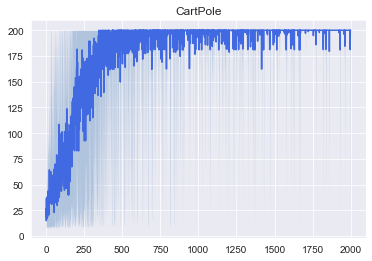

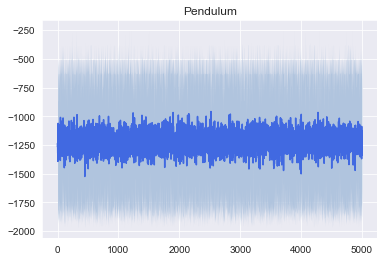

In [13]:
import seaborn as sns
import pickle

sns.set_style('darkgrid')
# plt.plot(avg_rewards,color='royalblue')
# plt.fill_between(np.arange(0,len(avg_rewards),1),min_rewards,max_rewards,facecolor='lightsteelblue',linewidth=0)

for j in ['CartPole','Pendulum']:
    dat = pickle.load(open("./"+j+"/data.pkl", "rb"))
    plt.title(j)
    plt.plot(dat['avg_reward'],color='royalblue')
    plt.fill_between(np.arange(0,len(dat['avg_reward']),1),dat['min_reward'],dat['max_rewards'],facecolor='lightsteelblue',linewidth=0)
    plt.show()

## 5. References

[Karpathy's Blog](https://gist.github.com/karpathy/77fbb6a8dac5395f1b73e7a89300318d)

[Evolution directed towards Exploration](https://papers.nips.cc/paper/7750-improving-exploration-in-evolution-strategies-for-deep-reinforcement-learning-via-a-population-of-novelty-seeking-agents.pdf)

[A more readable version of the code in PyTorch](https://github.com/staturecrane/PyTorch-ES)

[Dreamer (This paper came out a couple of days back and makes use of images to imagine 'k' states)](https://arxiv.org/pdf/1912.01603.pdf)